In [ ]:
!pip install stopwords

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from textblob import TextBlob
import stopwords
from collections import Counter
from wordcloud import WordCloud

In [ ]:
train_data = pd.read_csv("./text.csv")

In [ ]:
train_data.head()

,id,text,label
0,0,i just feel really helpless and heavy hearted,4.0
1,1,ive enjoyed being able to slouch about relax a...,0.0
2,2,i gave up my internship with the dmrg and am f...,4.0
3,3,i dont know i feel so lost,0.0
4,4,i am a kindergarten teacher and i am thoroughl...,4.0


In [ ]:
train_data.tail()

,id,text,label
146237,78445,ive been desperately trying to finish up my ma...,1.0
146238,78446,i feel angry when somebody is unjust to me,3.0
146239,78447,i could feel adunni s eye boring into the side...,0.0
146240,78448,i have mae and i know i m doing the same thing...,1.0
146241,78449,im going to feel irr,NaN


In [ ]:
train_data.describe()

,id,label
count,146242.000000,146241.000000
mean,158737.324496,1.550687
std,130313.683199,1.490140
min,0.000000,0.000000
25%,36560.250000,0.000000
50%,73120.500000,1.000000
75%,294374.750000,3.000000
max,330935.000000,5.000000


In [ ]:
train_data.isnull().sum()

id       0
text     0
label    1
dtype: int64

In [ ]:
train_data['label'].value_counts()

label
1.0    49403
0.0    42697
3.0    19954
4.0    16649
2.0    12259
5.0     5279
Name: count, dtype: int64

Nhận xét:
- Label có 4 giá trị: 0, 1, 2, 3, 4, 5
- Cột label có 1 giá trị null.
- Các cột khác không có giá trị null.

Có thể bỏ giá trị null ở cột label vì số lượng giá trị null rất ít (chỉ có 1 giá trị). Hoặc có thể gán nhãn rỗng bằng nhãn thường xuyên nhất

In [ ]:
most_frequent_label = train_data['label'].value_counts().index[0]
train_data['label'].fillna(value=most_frequent_label, inplace=True)
train_data.isnull().sum()

id       0
text     0
label    0
dtype: int64

# Phân tích cảm xúc

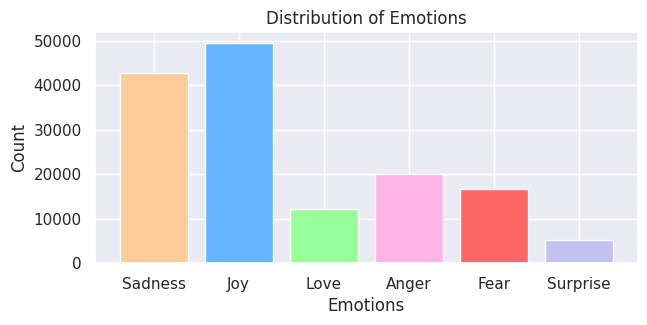

In [ ]:
labels = train_data['label']
label_dict = {0: 'Sadness', 1: 'Joy', 2: 'Love', 3: 'Anger', 4: 'Fear', 5: 'Surprise'}
label_counts = Counter(labels)
labels = list(label_counts.keys())
values = list(label_counts.values())
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff', '#c2c2f0', '#ffb3e6']
plt.figure(figsize=(7, 3))
plt.bar(labels, values, color=colors)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.xticks(labels, [label_dict[label] for label in labels])
plt.show()


# Phân tích quan điểm

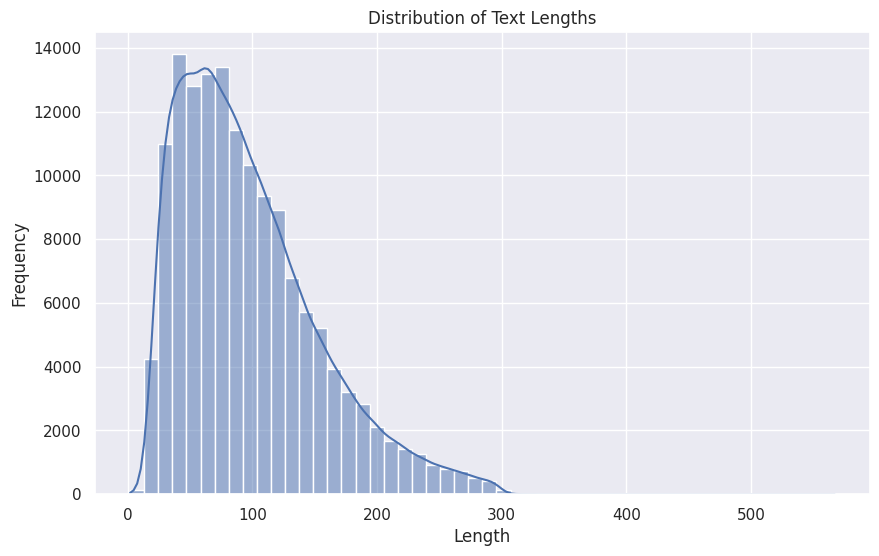

In [ ]:
train_data['length'] = train_data['text'].apply(len)
train_data.head()
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='length', bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

- Biểu đồ cho thấy độ dài của các văn bản trong tập dữ liệu phân bố không đều.
- Đa số các văn bản có độ dài từ 0 đến 50 ký tự.
- Có một số ít văn bản có độ dài lớn hơn 100 ký tự.
- Độ dài trung bình của các văn bản là khoảng 50 ký tự.

Tính ảnh hưởng văn bản

In [ ]:
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
train_data['polarity'] = train_data['text'].apply(get_polarity)

Tính chủ quan của văn bản

In [ ]:
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
train_data['subjectivity'] = train_data['text'].apply(get_subjectivity)

In [ ]:
train_data[['length', 'polarity','subjectivity', 'text']]

,length,polarity,subjectivity,text
0,45,0.000,0.350000,i just feel really helpless and heavy hearted
1,234,0.025,0.448611,ive enjoyed being able to slouch about relax a...
2,63,-0.600,1.000000,i gave up my internship with the dmrg and am f...
3,26,0.000,0.000000,i dont know i feel so lost
4,222,0.000,1.000000,i am a kindergarten teacher and i am thoroughl...
...,...,...,...,...
146237,221,-0.160,0.700000,ive been desperately trying to finish up my ma...
146238,42,-0.500,1.000000,i feel angry when somebody is unjust to me
146239,88,-1.000,1.000000,i could feel adunni s eye boring into the side...
146240,117,0.000,0.125000,i have mae and i know i m doing the same thing...


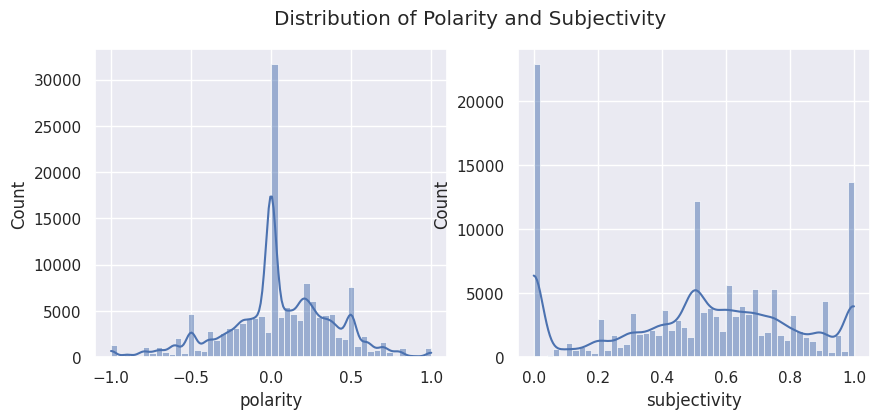

In [ ]:
plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.histplot(train_data['polarity'], bins=50, kde=True)

plt.subplot(1, 2, 2)
sns.histplot(train_data['subjectivity'], bins=50, kde=True)

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

**Nhận xét:**

- Biểu đồ phân bố của Polarity cho thấy rằng các văn bản trong tập dữ liệu có xu hướng tiêu cực hơn là tích cực. Điều này có thể là do bản chất của các văn bản trong tập dữ liệu, chẳng hạn như các văn bản về các sự kiện tiêu cực hoặc các bài viết về các vấn đề xã hội.
- Biểu đồ phân bố của Subjectivity cho thấy rằng các văn bản trong tập dữ liệu có xu hướng khách quan hơn là chủ quan. Điều này có thể là do các văn bản trong tập dữ liệu được viết với mục đích thông tin hoặc cung cấp thông tin, chứ không phải để bày tỏ quan điểm cá nhân.

**Ý nghĩa:**

- Kết quả của 2 biểu đồ này có thể được sử dụng để hiểu rõ hơn về bản chất của các văn bản trong tập dữ liệu.
- Ví dụ, kết quả này có thể được sử dụng để lựa chọn các phương pháp phân tích văn bản phù hợp, chẳng hạn như các phương pháp phân tích tình cảm hoặc các phương pháp phân tích chủ quan.
- Ngoài ra, kết quả này cũng có thể được sử dụng để hiểu rõ hơn về tác giả của các văn bản, chẳng hạn như khuynh hướng chính trị của tác giả hoặc quan điểm cá nhân của tác giả.

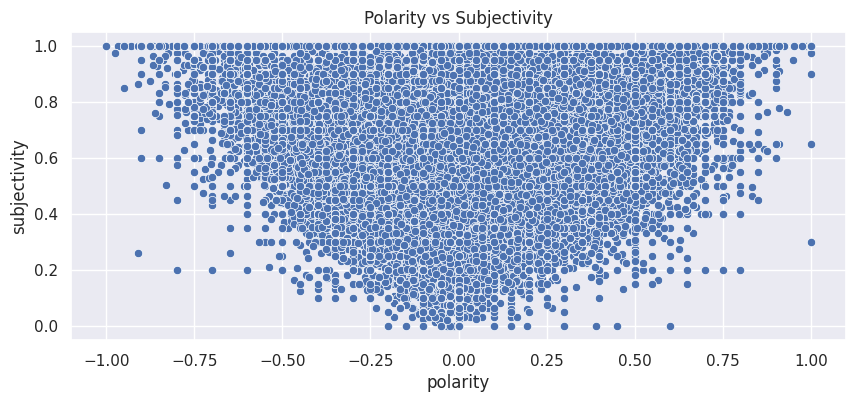

In [ ]:
sns.scatterplot(x = train_data['polarity'], y = train_data['subjectivity'])
plt.title('Polarity vs Subjectivity')
plt.show()

- Biểu đồ cho thấy rằng có một mối tương quan tích cực giữa polarity và subjectivity. Điều này có nghĩa là các văn bản có xu hướng tích cực hơn cũng có xu hướng chủ quan hơn.
- Điều này có thể là do các văn bản tích cực thường được viết với mục đích bày tỏ cảm xúc hoặc quan điểm cá nhân, trong khi các văn bản tiêu cực thường được viết với mục đích thông tin hoặc cung cấp thông tin.

<Axes: >

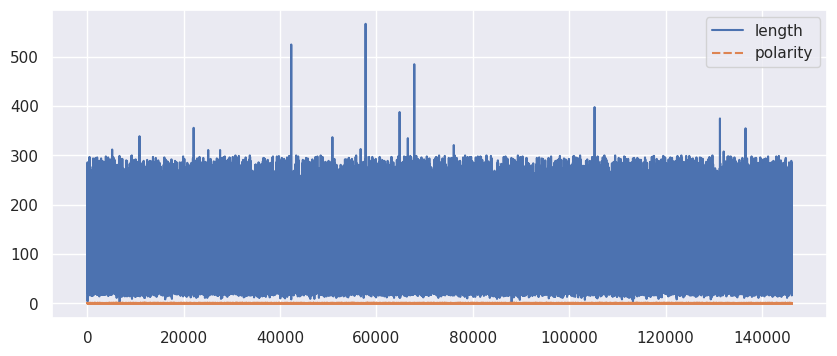

In [ ]:
sns.lineplot(data=train_data.drop(['subjectivity', 'label', 'id'], axis=1))

<Axes: >

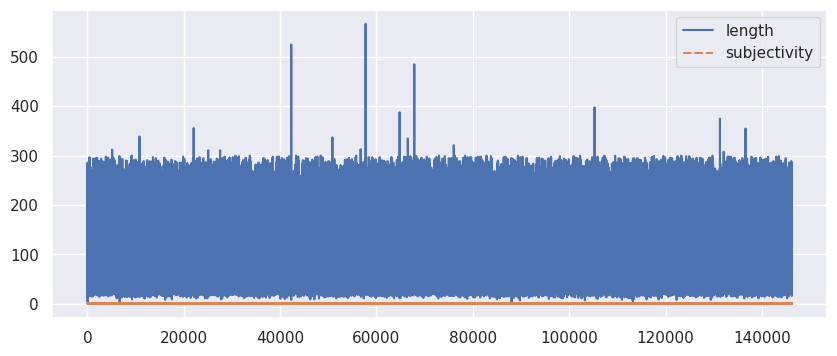

In [ ]:
sns.lineplot(data=train_data.drop(['polarity', 'label', 'id'], axis=1))

- Cả 2 biểu đồ cho thấy rằng độ dài trung bình của các văn bản trong tập dữ liệu tăng theo độ dài của các từ trong văn bản.
- Điều này có nghĩa là các văn bản dài hơn thường có nhiều từ dài hơn.
- Điều này có thể là do các văn bản dài hơn thường được viết với mục đích cung cấp thông tin hoặc trình bày các ý tưởng phức tạp, trong khi các văn bản ngắn hơn thường được viết với mục đích giao tiếp đơn giản hoặc truyền đạt thông tin nhanh chóng

# Trực quan hóa số lượng từ dừng có trong tập dữ liệu

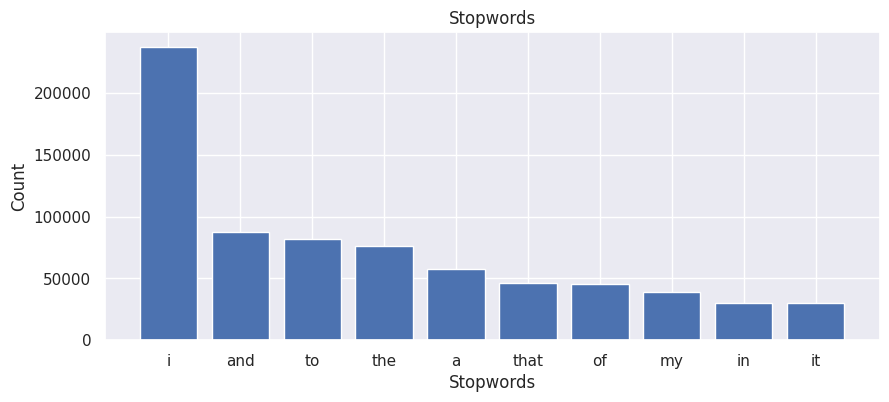

In [ ]:
data=train_data['text']
stop=set(stopwords.get_stopwords('english'))
data_split= data.str.split()
data_list=data_split.values.tolist()
corpus=[word for i in data_list for word in i]
from collections import defaultdict
dictionary_stopwords=defaultdict(int)
for word in corpus:
    if word in stop:
        dictionary_stopwords[word]+=1

top=sorted(dictionary_stopwords.items(), key=lambda x:x[1],reverse=True)[:10]
x,y=zip(*top)
plt.bar(x,y)
plt.xlabel('Stopwords')
plt.ylabel('Count')
plt.title('Stopwords')
plt.show()

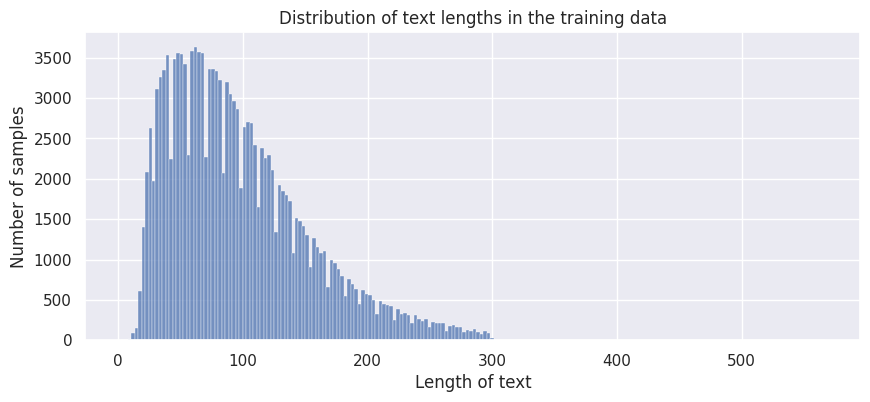

In [ ]:
sns.histplot(train_data['text'].apply(lambda x: len(x)))
plt.xlabel('Length of text')
plt.ylabel('Number of samples')
plt.title('Distribution of text lengths in the training data')
plt.show()

Nhìn vào biểu đồ, ta có thể thấy rằng hầu hết các văn bản trong tập dữ liệu có độ dài dưới 100 ký tự. Số lượng các văn bản có độ dài trên 100 ký tự giảm dần theo độ dài của văn bản.

Điều này cho thấy rằng các văn bản trong tập dữ liệu huấn luyện thường có độ dài ngắn. Điều này có thể là do bản chất của các văn bản trong tập dữ liệu, chẳng hạn như các văn bản về các sự kiện hiện tại hoặc các bài viết trên mạng xã hội.

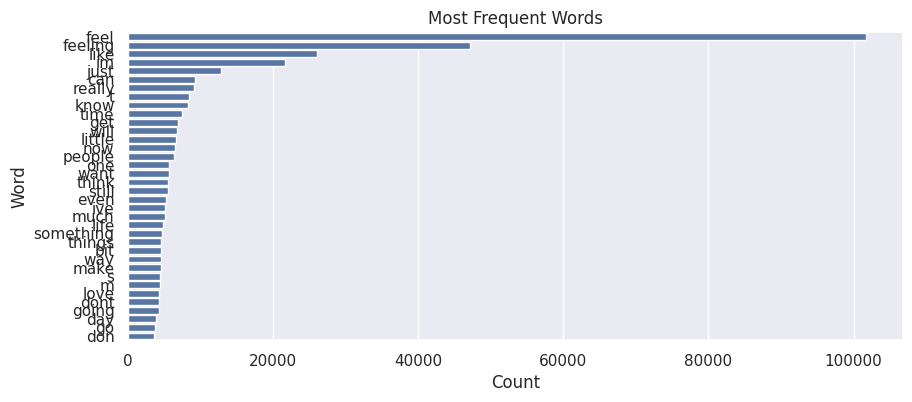

In [ ]:
data=train_data['text']
stop=set(stopwords.get_stopwords('english'))
data_split= data.str.split()
data_list=data_split.values.tolist()
corpus=[word for i in data_list for word in i]
counter=Counter(corpus)
mostCommon=counter.most_common()
x, y=[], []
for word,count in mostCommon[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Most Frequent Words')
plt.show()

Nhìn vào biểu đồ, ta có thể thấy rằng các từ xuất hiện nhiều nhất trong tập dữ liệu là các stopwords, chẳng hạn như "the", "of", "and", "a", "to", "in", "is", "it", "that", "are". Các từ này thường xuất hiện trong hầu hết các câu văn tiếng Anh và không mang nhiều ý nghĩa cụ thể.

Ngoài các stopwords, biểu đồ cũng cho thấy một số từ nội dung xuất hiện nhiều lần, chẳng hạn như "love", "like", "you", "just", "can", "know", "heart", "time", "people". Các từ này thường mang nhiều ý nghĩa cụ thể và được sử dụng để diễn đạt các cảm xúc, suy nghĩ và ý tưởng của người viết.

Tần suất xuất hiện của các từ trong biểu đồ có thể được sử dụng để hiểu rõ hơn về nội dung và phong cách của các văn bản trong tập dữ liệu. Ví dụ, sự xuất hiện nhiều của các stopwords cho thấy rằng các văn bản trong tập dữ liệu thường có cấu trúc đơn giản và dễ hiểu. Sự xuất hiện của các từ nội dung cho thấy rằng các văn bản trong tập dữ liệu thường đề cập đến các chủ đề tình yêu, cảm xúc, cuộc sống và thế giới xung quanh.

# Word cloud

Ta sẽ xây dựng xây dựng một đám mây từ theo danh mục để chứng minh những thuật ngữ thường gặp nhất cho từng danh mục. Điều này sẽ cho chúng tôi ý tưởng ngắn gọn nếu có bất kỳ từ thường gặp nào phân tách dữ liệu của chúng tôi ở một mức độ nào đó

In [ ]:
train_data["label"].unique()

array([4., 0., 2., 1., 5., 3.])

In [ ]:
sadness = ' '.join(list(train_data.text[train_data["label"] == 0]))
joy = ' '.join(list(train_data.text[train_data["label"] == 1]))
love = ' '.join(list(train_data.text[train_data["label"] == 2]))
anger = ' '.join(list(train_data.text[train_data["label"] == 3]))
fear = ' '.join(list(train_data.text[train_data["label"] == 4]))
surprise = ' '.join(list(train_data.text[train_data["label"] == 5]))

In [ ]:
def word_cloud(text, title):
    wordcloud = WordCloud(
        width = 1600,
        height = 1000,
        background_color = "black",
        stopwords = set(stopwords.get_stopwords('english')),
        min_font_size = 8
    ).generate(text)

    plt.figure(figsize = (12, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.title("Word Cloud for " + title + " Emotion\n", fontsize = 20)
    plt.axis("off")
    plt.show()

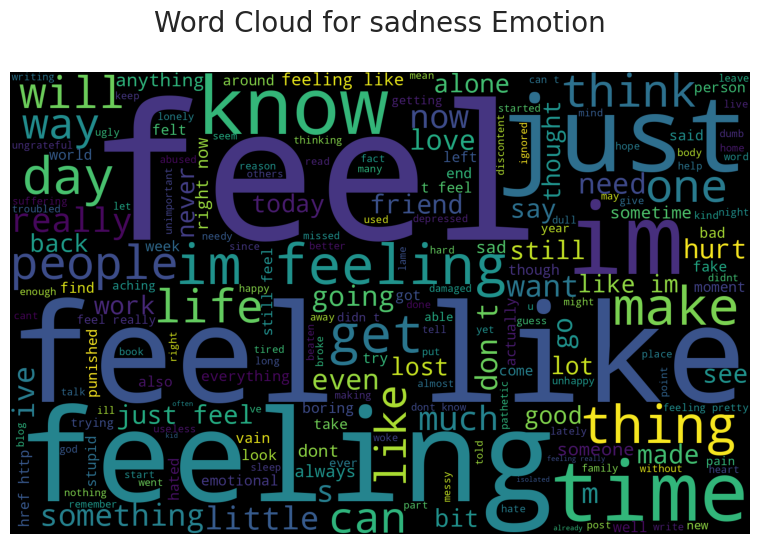

In [ ]:
word_cloud(sadness, "sadness")

- Những từ thường gặp nhất trong đám mây từ buồn là "sad", "heart", "alone", "pain" và "cry". Những từ này đều truyền tải cảm giác buồn bã, cô đơn và đau đớn.

- Đám mây từ cũng bao gồm một số từ gắn liền với các sự kiện tiêu cực, chẳng hạn như "death", "loss", và "goodbye". Những từ này cho thấy nỗi buồn thường được gây ra bởi những trải nghiệm tiêu cực trong cuộc sống.

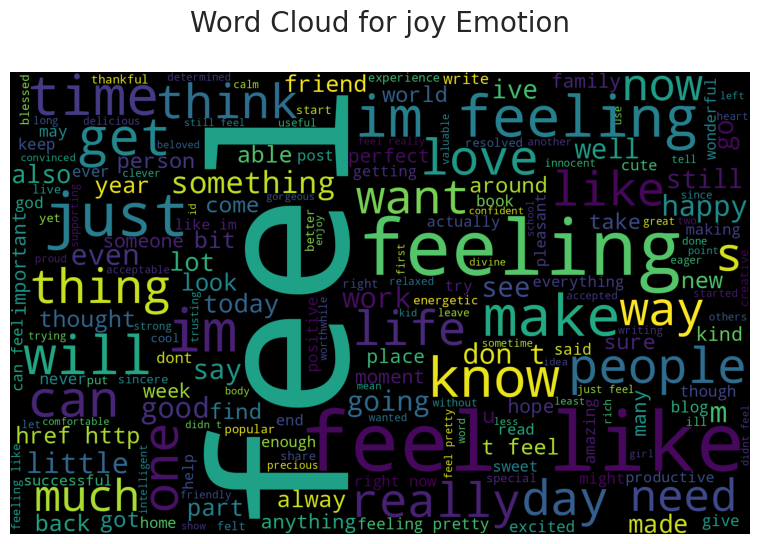

In [ ]:
word_cloud(joy, "joy")

- Những từ phổ biến nhất trong đám mây từ vui vẻ là "happy", "love", "smile", và "laugh". Những lời này đều truyền tải cảm giác vui vẻ, hạnh phúc và mãn nguyện.

- Đám mây từ cũng bao gồm một số từ gắn liền với các sự kiện tích cực, chẳng hạn như "party", "celebrate", và "success". Những từ này gợi ý rằng niềm vui thường được kích hoạt bởi những trải nghiệm sống tích cực.

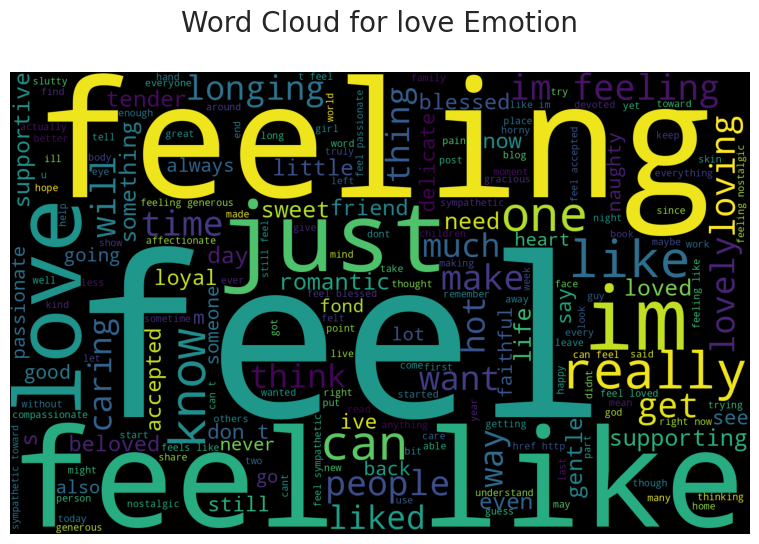

In [ ]:
word_cloud(love, "love")

- Những từ phổ biến nhất trong đám mây từ tình yêu là "love", "heart", "kiss", và "romance". Những từ này đều truyền tải cảm xúc của tình yêu, tình cảm và sự lãng mạn.

- Đám mây từ cũng bao gồm một số từ gắn liền với các mối quan hệ, chẳng hạn như "partner", "girlfriend", và "boyfriend". Những từ này gợi ý rằng tình yêu thường gắn liền với những mối quan hệ lãng mạn.

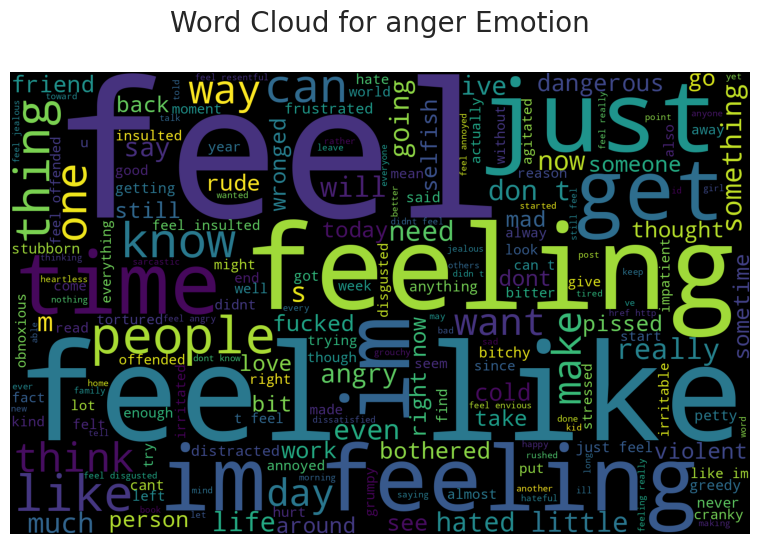

In [ ]:
word_cloud(anger, "anger")

- Những từ phổ biến nhất trong đám mây từ giận dữ là "angry", "mad", "hate", và "rage". Những từ này đều truyền đạt cảm giác tức giận, thù địch và hung hăng.

- Đám mây từ còn bao gồm một số từ gắn liền với những hành vi tiêu cực như "fight", "violence", và "destruction". Những từ này cho thấy sự tức giận thường gắn liền với những hành vi phá hoại.

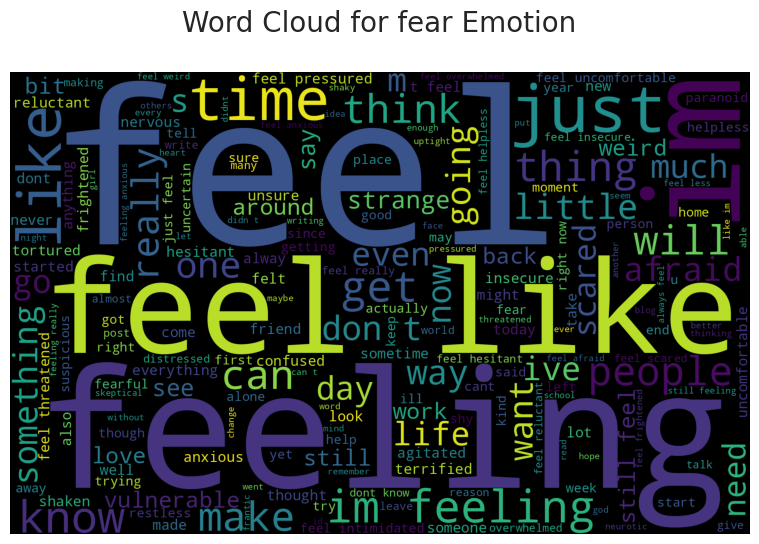

In [ ]:
word_cloud(fear, "fear")

- Những từ phổ biến nhất trong đám mây từ sợ hãi là "fear", "afraid", "scared", and "anxiety". Những từ này đều truyền tải cảm giác sợ hãi, lo lắng và lo lắng.

- Đám mây từ cũng bao gồm một số từ có liên quan đến các tình huống nguy hiểm, chẳng hạn như "danger", "threat", và "risk". Những từ này gợi ý rằng nỗi sợ hãi thường được kích hoạt bởi những mối đe dọa được nhận thấy đối với sự an toàn.

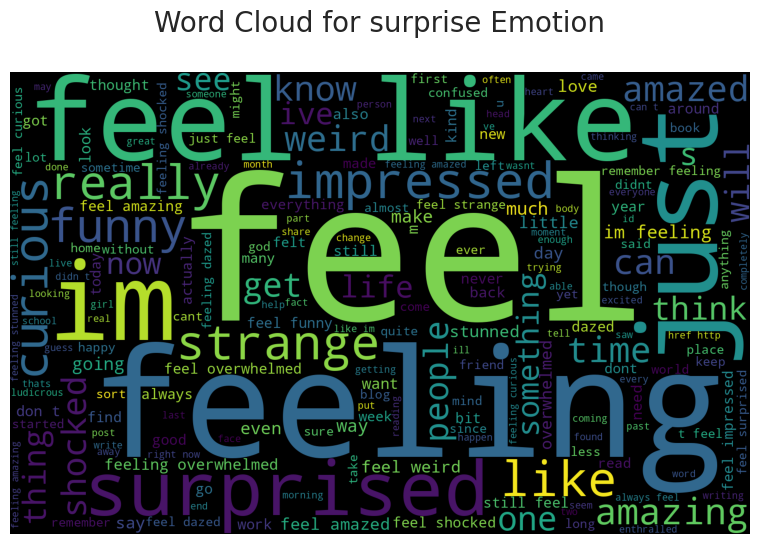

In [ ]:
word_cloud(surprise, "surprise")

- Những từ thường gặp nhất trong đám mây từ bất ngờ là "surprise", "shocked", "amazed", và "unexpected". Những từ này đều truyền tải cảm giác ngạc nhiên, ngạc nhiên và ngạc nhiên.

- Đám mây từ cũng bao gồm một số từ gắn liền với các sự kiện tích cực, chẳng hạn như "gift", "present", và "birthday". Những từ này gợi ý rằng sự ngạc nhiên thường gắn liền với những trải nghiệm sống tích cực.